In [18]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from scpert import config
from scpert.model import PertNet
from socube.utils import loadTorchModule
from scpert.data import padding_data, PertDataset
from venn import venn

In [2]:
plt.style.use("seaborn-white")
plt.rcParams["savefig.facecolor"] = "auto"
plt.rcParams["savefig.edgecolor"] = "auto"
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 12
sc.set_figure_params(fontsize=14, vector_friendly=True, dpi=300)

In [3]:
pbmc_train = sc.read_h5ad("datasets/scGEN/train_pbmc_clear.h5ad")
pbmc_train_padding = padding_data(pbmc_train, 7000 - pbmc_train.shape[1])

In [4]:
cell_types = ["B", "CD4T", "CD8T", "CD14+Mono", "Dendritic", "FCGR3A+Mono", "NK"]
select_cell = "CD14+Mono"

### Interpretation by feature weights

In [7]:
data_by_celltype = pbmc_train[pbmc_train.obs["cell_type"] == select_cell]
sc.tl.rank_genes_groups(data_by_celltype, groupby=config.CONDITION_COL, method="wilcoxon")
diff_genes_by_celltype = data_by_celltype.uns["rank_genes_groups"]["names"][config.TARGET_NAME]

/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [8]:
model = PertNet(140, 7000, 10, 6, 2)
model = loadTorchModule(model, f"models/scPert/20221013-222528-643/{select_cell}/{PertNet.__name__}_1.pt", skipped=False)

2022-10-23 19:20:31,958 - loadTorchModule - INFO - model models/scPert/20221013-222528-643/CD14+Mono/PertNet_1.pt loaded


In [9]:
gene_weights = pd.Series(
    model._weight.data[:, :pbmc_train.shape[1]].detach().flatten().abs().numpy(),
    index=pbmc_train.var_names
)

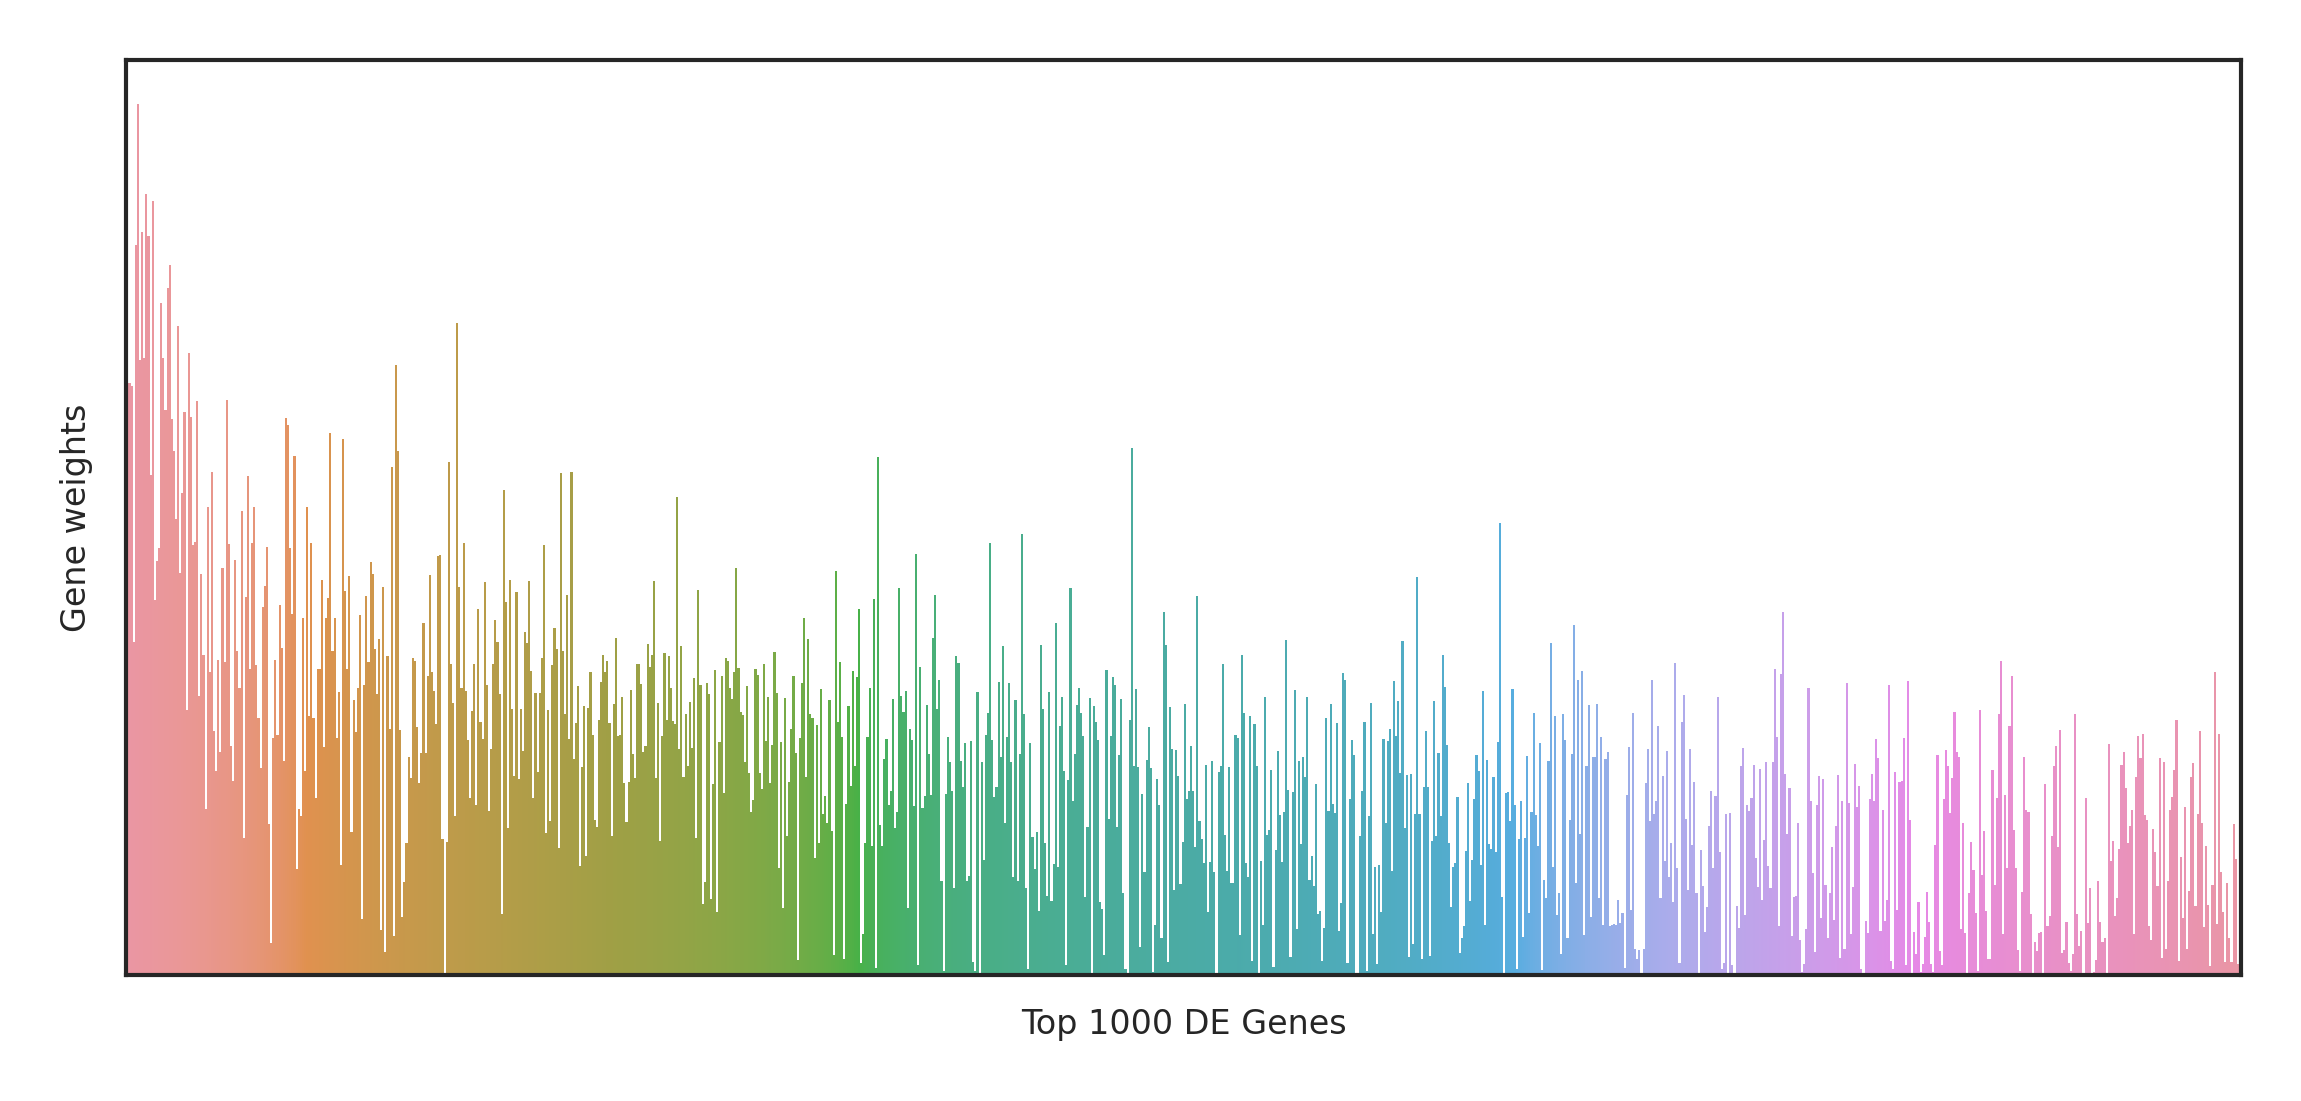

In [10]:
top_deg_num = 1000
weight_of_diff_genes = gene_weights[diff_genes_by_celltype][:top_deg_num]
sns.set_theme(style="ticks", rc={"figure.figsize": (4, 2)})
sns.barplot(y=weight_of_diff_genes.values, x=weight_of_diff_genes.index, width=1, linewidth=0)
ax = plt.gca()
plt.xlabel(f"Top {top_deg_num} DE Genes", fontsize=4)
plt.ylabel("Gene weights", fontsize=4)
plt.yticks([])
# set the tick labels fontsize=2, rotation=90 and 
plt.xticks(fontsize=2, rotation=90, ticks=[])
# no tick short line
plt.tick_params(length=0)
# set spines line width
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0.5)
ax.spines['top'].set_linewidth(0.5)
plt.tight_layout()
plt.savefig(f"figures/interpretation/weight_of_diff_genes_{select_cell}.pdf", dpi=300)

In [15]:
diff_by_weights = gene_weights.sort_values(ascending=False)[:50].index
diff_by_weights.intersection(diff_genes_by_celltype[:50])

Index(['IFIT3', 'CXCL10', 'CCL8', 'RSAD2', 'IFIT2', 'TNFSF10', 'GBP1', 'MT2A',
       'IRF7', 'CCL2', 'SAMD9', 'IFIT1', 'SAT1', 'IFI6', 'ISG20', 'IFITM3',
       'CTSC', 'HERC5', 'OASL', 'NT5C3A', 'CMPK2', 'TYMP', 'FAM26F', 'EIF2AK2',
       'IDO1'],
      dtype='object', name='index')

## Interpretation by delta value prediction

/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


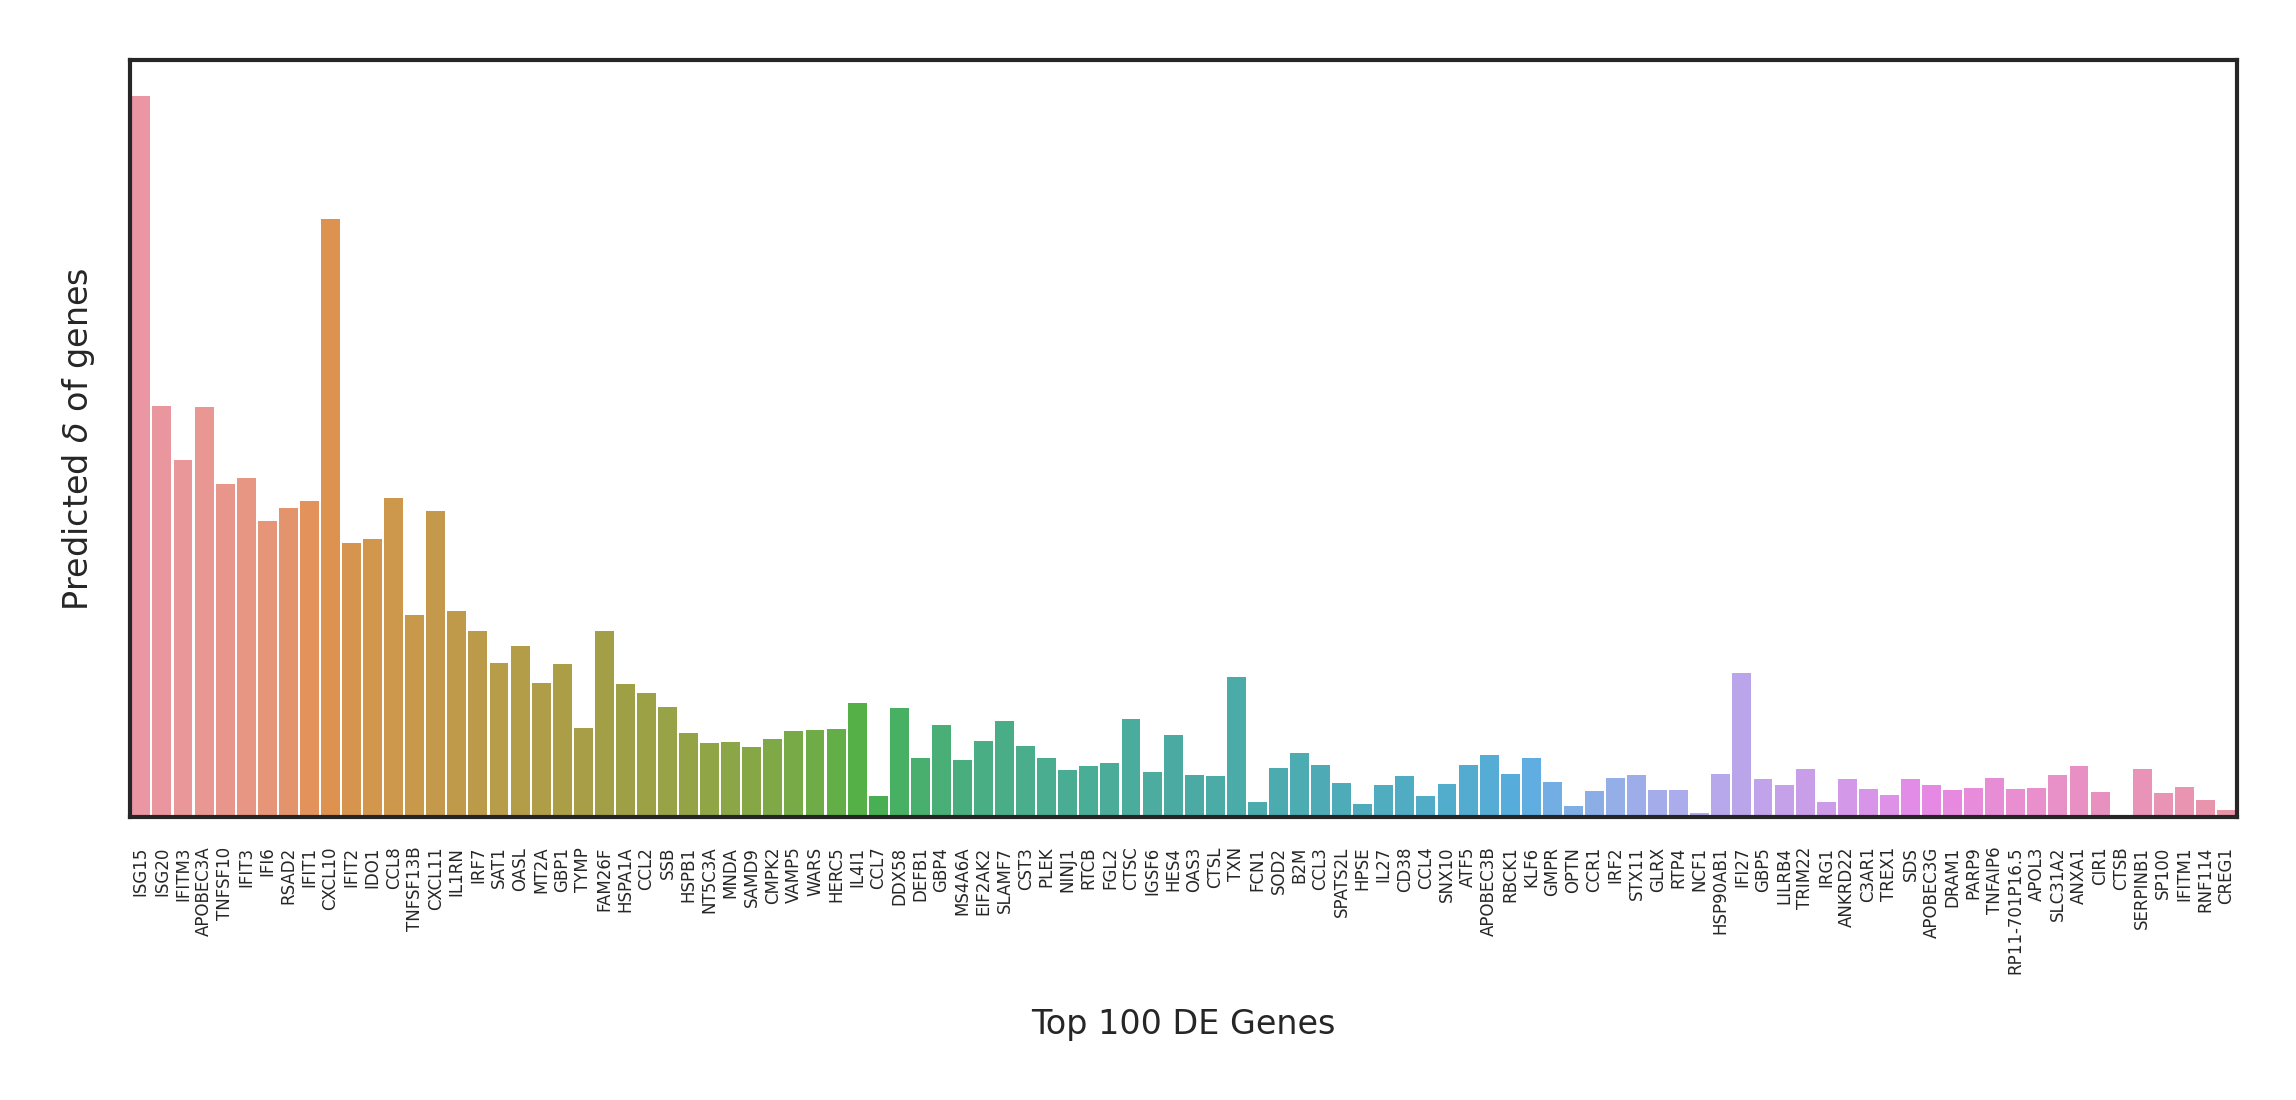

In [6]:
data_by_celltype = pbmc_train[pbmc_train.obs["cell_type"] == select_cell]
sc.tl.rank_genes_groups(data_by_celltype, groupby=config.CONDITION_COL, method="wilcoxon")
diff_genes_by_celltype = data_by_celltype.uns["rank_genes_groups"]["names"][config.TARGET_NAME]
ctrl_by_celltype = data_by_celltype[data_by_celltype.obs[config.CONDITION_COL] == config.SOURCE_NAME]
pred_by_celltype = sc.read_h5ad(f"outputs/scPert/20221013-222528-643/{select_cell}/predict.h5ad")
delta = pd.DataFrame(
    pred_by_celltype.X - ctrl_by_celltype.X, 
    index=ctrl_by_celltype.obs_names, 
    columns=pred_by_celltype.var_names)
delta = delta.mean(axis=0)
delta = delta.abs().sort_values(ascending=False)

delta_of_diff_genes = delta[diff_genes_by_celltype[:100]]
sns.set_theme(style="ticks", rc={"figure.figsize": (4, 2)})
sns.barplot(y=delta_of_diff_genes.values, x=delta_of_diff_genes.index, width=0.9, linewidth=0)
ax = plt.gca()
plt.xlabel("Top 100 DE Genes", fontsize=4)
plt.ylabel(r"Predicted $\delta$ of genes", fontsize=4)
plt.yticks([])
# set the tick labels fontsize=2, rotation=90 and 
plt.xticks(fontsize=2, rotation=90)
# no tick short line
plt.tick_params(length=0)
# set spines line width
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0.5)
ax.spines['top'].set_linewidth(0.5)
plt.tight_layout()
plt.savefig(f"figures/interpretation/delta_of_diff_genes_{select_cell}.pdf", dpi=300)

In [32]:
diff_gene_by_delta = delta.index[:50]
common_gene = pd.Index(diff_genes_by_celltype[:50]).intersection(diff_gene_by_delta).intersection(diff_by_weights)

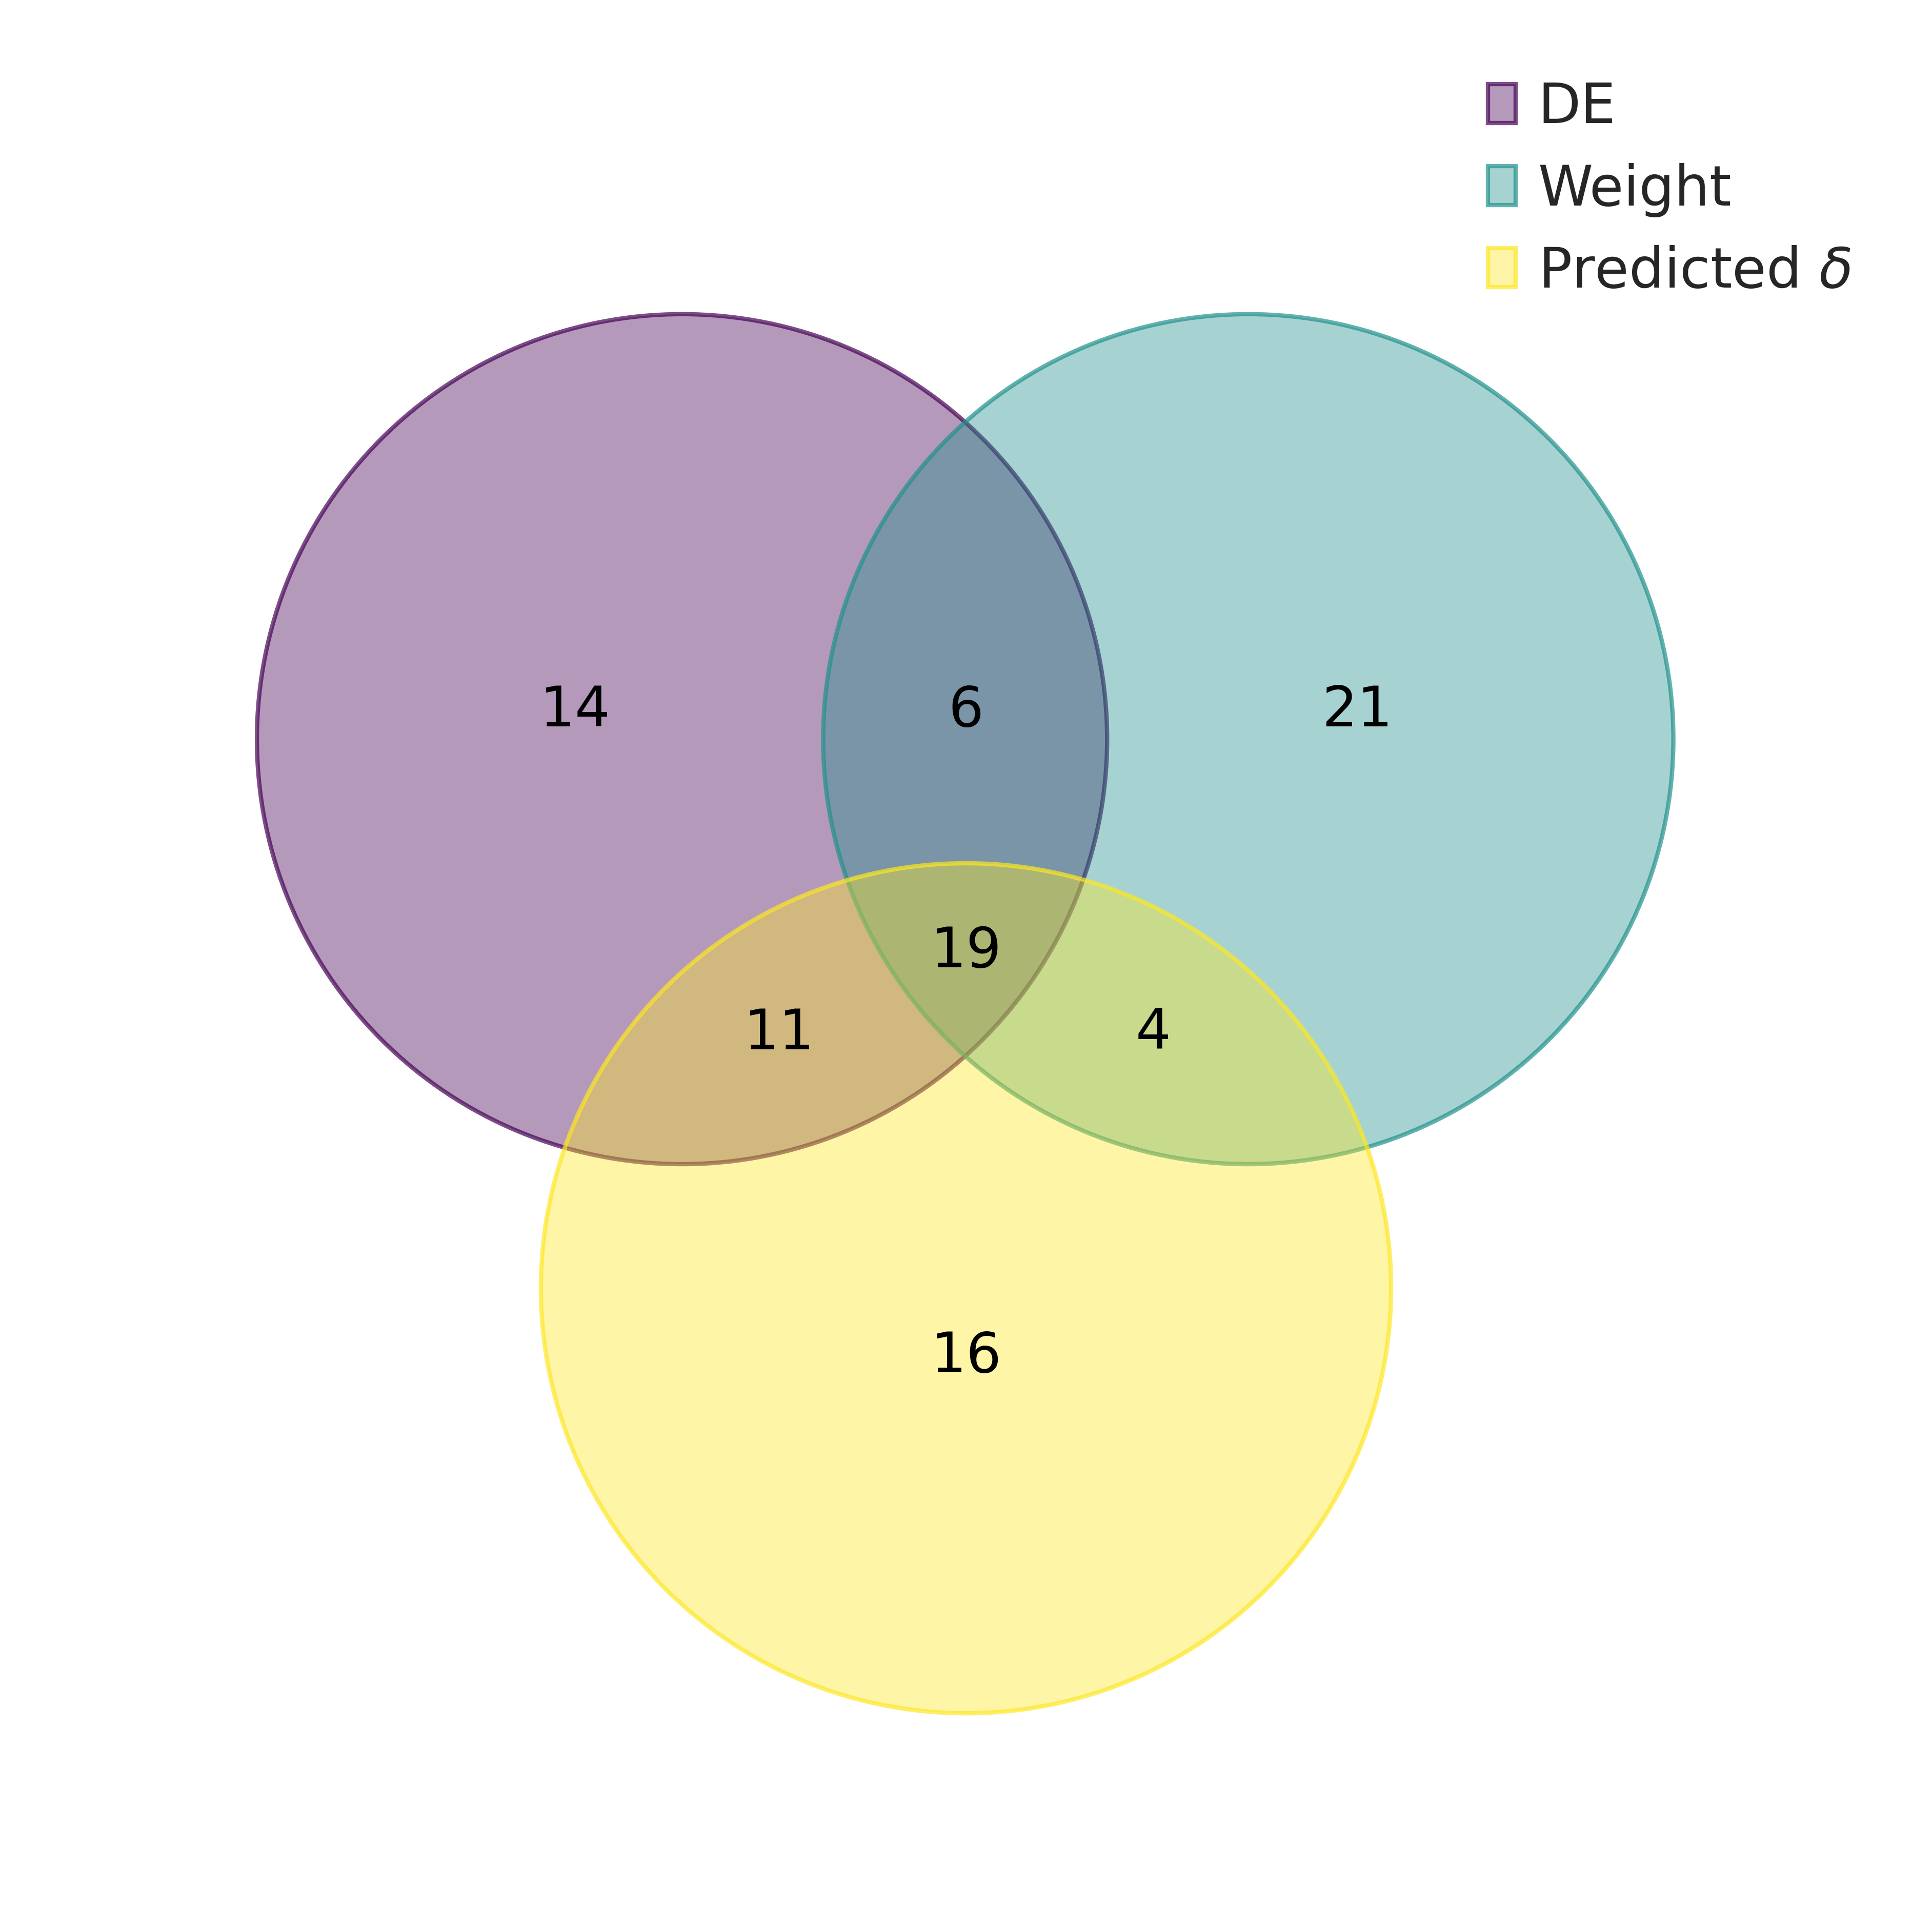

In [25]:
sns.set_style(rc={"figure.figsize": (2, 2)})
venn({"DE": set(diff_genes_by_celltype[:50]), "Weight": set(diff_by_weights), r"Predicted $\delta$": set(diff_gene_by_delta)})
plt.savefig(f"figures/interpretation/venn_{select_cell}.pdf", dpi=300)

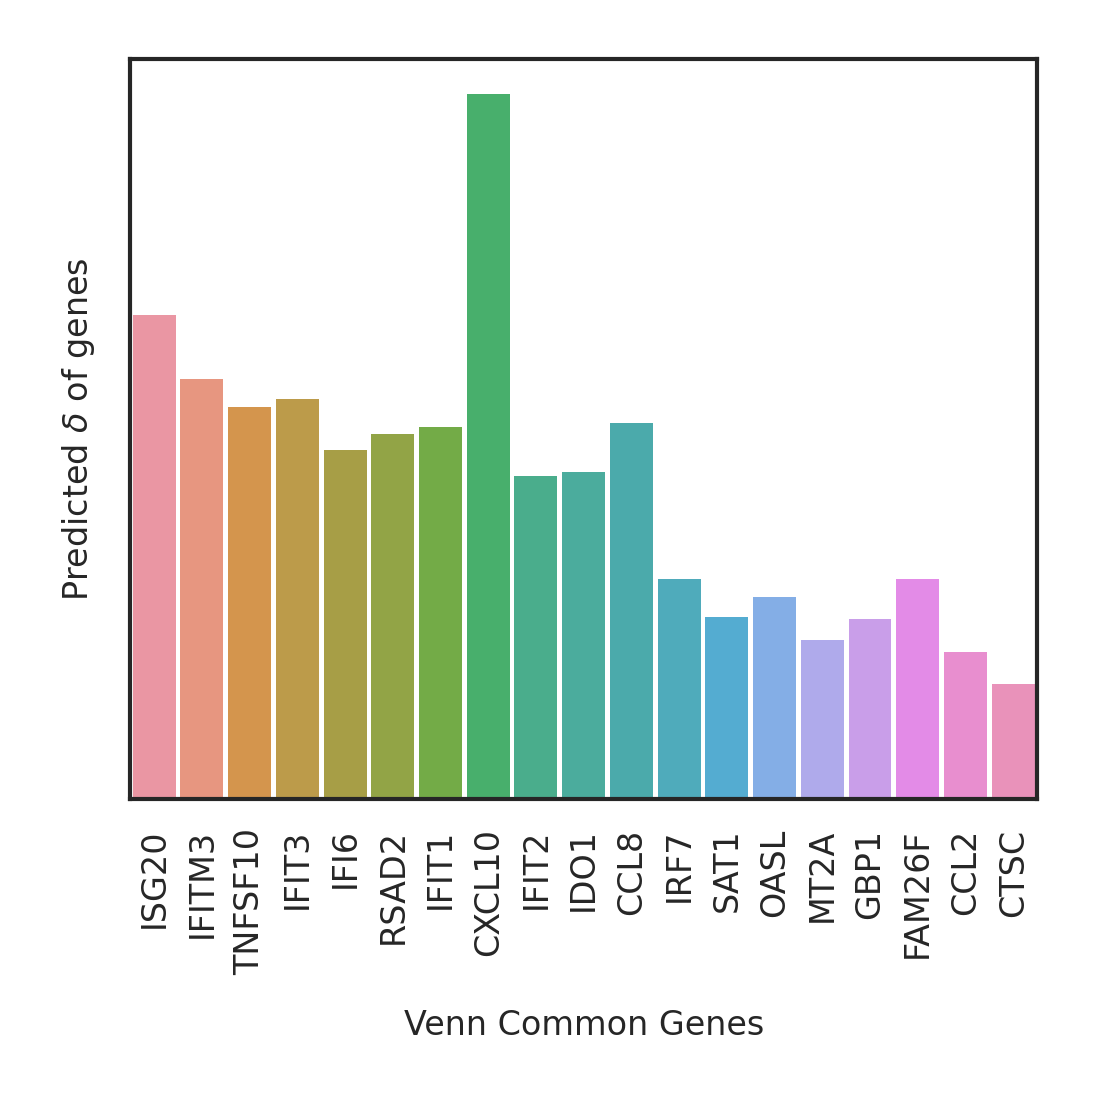

In [33]:
delta_of_diff_genes = delta[common_gene]
sns.set_theme(style="ticks", rc={"figure.figsize": (2, 2)})
sns.barplot(y=delta_of_diff_genes.values, x=delta_of_diff_genes.index, width=0.9, linewidth=0)
ax = plt.gca()
plt.xlabel("Venn Common Genes", fontsize=4)
plt.ylabel(r"Predicted $\delta$ of genes", fontsize=4)
plt.yticks([])
# set the tick labels fontsize=2, rotation=90 and 
plt.xticks(fontsize=4, rotation=90)
# no tick short line
plt.tick_params(length=0)
# set spines line width
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0.5)
ax.spines['top'].set_linewidth(0.5)
plt.tight_layout()
plt.savefig(f"figures/interpretation/venn_common_genes_{select_cell}.pdf", dpi=300)